In [5]:
import imageio
import requests
import torch
from diffusers import AnimateDiffVideoToVideoPipeline, DDIMScheduler, MotionAdapter
from diffusers.utils import export_to_gif
from io import BytesIO
from PIL import Image
from diffusers.utils import export_to_gif, export_to_video
import os

# Load the motion adapter
adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16)
# load SD 1.5 based finetuned model
model_id = "JosephusCheung/ACertainThing"
pipe = AnimateDiffVideoToVideoPipeline.from_pretrained(model_id, motion_adapter=adapter, torch_dtype=torch.float16).to("cuda")
scheduler = DDIMScheduler.from_pretrained(
    model_id,
    subfolder="scheduler",
    clip_sample=False,
    timestep_spacing="linspace",
    beta_schedule="linear",
    steps_offset=1,
)
pipe.scheduler = scheduler

# enable memory savings
pipe.enable_vae_slicing()
pipe.enable_model_cpu_offload()

# helper function to load videos
def load_video(file_path: str):
    images = []

    if file_path.startswith(('http://', 'https://')):
        # If the file_path is a URL
        response = requests.get(file_path)
        response.raise_for_status()
        content = BytesIO(response.content)
        vid = imageio.get_reader(content)
    else:
        # Assuming it's a local file path
        vid = imageio.get_reader(file_path)

    for frame in vid:
        pil_image = Image.fromarray(frame)
        images.append(pil_image)

    return images

video = load_video("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/animatediff-vid2vid-input-1.gif")

output = pipe(
    video = video,
    prompt="a girl playing a guitar, on a boat, in the ocean, 1girl, solo, high quality",
    negative_prompt="bad quality, worse quality",
    guidance_scale=9.0,
    num_inference_steps=25,
    strength=0.9, # 少し強めにかける、Img2imgと同じでstrengthを上げるとstep数が増える
    width=512,
    height=512,
    generator=torch.Generator("cpu").manual_seed(42),
    clip_skip=2 # モデル特有の設定
)
frames = output.frames[0]
output_path = "generated/21_v2v_anime"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
export_to_video(frames, output_path+".mp4")
export_to_gif(frames, output_path+".gif")

The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint at /root/.cache/huggingface/hub/models--JosephusCheung--ACertainThing/snapshots/f29dbc8b2737fa20287a7ded5c47973619b5c012/text_encoder were not used when initializing CLIPTextModel: ['text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.11.layer_norm1.weight', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.11.layer_norm2.weight', 'text_model.encoder.layers.11.mlp.fc1.bias', 'text_model.encoder.layers.11.mlp.fc1.weight', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.11.mlp.fc2.weight', 'text_model.encoder.layers.11.self_attn.k_proj.bias', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layers.11.self_attn.out_proj.bias', 'text_model.encoder.layers.11.self_attn.out_proj.weight', 'text_model.encoder.layers.11.self_attn.q_proj.bias', 'text_model.encoder.layers.11.self_attn.q_proj.weight', 'text_model.encoder.layers.11.self_attn.v_proj.bias', 'text_mod

  0%|          | 0/22 [00:00<?, ?it/s]

'generated/21_v2v_anime.gif'

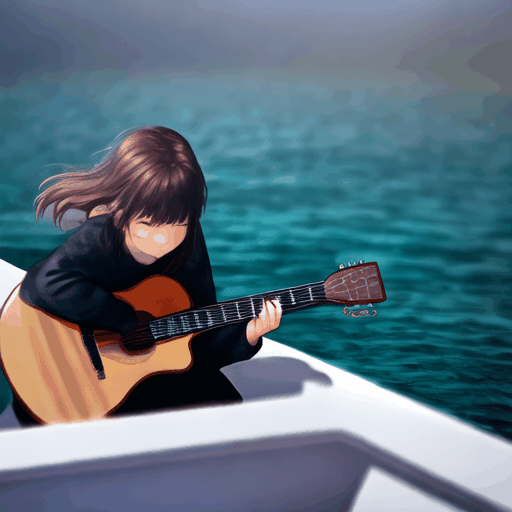

In [6]:
from IPython.display import Image

Image(output_path+".gif")

In [ ]:
## 7.2GB